### Notebook for plotting blob radii and stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tables as tb
from matplotlib import colors
from tqdm import tqdm
import json



from typing          import Optional
from typing          import Union
from typing          import Callable
from typing          import Any

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_include-cluster-dropping/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_include-cluster-dropping/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
import invisible_cities.core.core_functions                   as     coref
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

#from invisible_cities.cities import beersheba as beerfun
import glob
from tqdm import tqdm
# To get these back, figure out the compilation properly!
import functions.functions_HE as func
#from invisible_cities.cities.beersheba    import hitc_to_df_


### take in
- run number
- timestamp
- ldc
- file number
- index of the event

In [2]:
RUN_NUMBER     = '15591'
TIMESTAMP      = '456021'
SOPH_TIMESTAMP = '230725'
LDC            = 1
BLOB_RADIUS    = int(TIMESTAMP[:2])
SCAN_RADIUS    = int(TIMESTAMP[2:4])

In [3]:
thekla_path = f'/data/halmazan/NEXT/N100_LPR/{RUN_NUMBER}/thekla/{TIMESTAMP}/ldc{LDC}/'
#cut_path    = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RUN_NUMBER}/{TIMESTAMP}/cut_hdst.h5'
file_names = [f for f in os.listdir(thekla_path) if f.endswith('.h5')]
file_paths = [os.path.join(thekla_path, f) for f in file_names]

# the overwriter if you want it, allows for specific files to be picked out
file_paths = [f'/data/halmazan/NEXT/N100_LPR/15591/thekla/{TIMESTAMP}/ldc1/run_15591_2821_ldc1_230725_thekla.h5', f'/data/halmazan/NEXT/N100_LPR/15591/thekla/{TIMESTAMP}/ldc1/run_15591_2978_ldc1_230725_thekla.h5', f'/data/halmazan/NEXT/N100_LPR/15591/thekla/{TIMESTAMP}/ldc1/run_15591_0740_ldc1_230725_thekla.h5', f'/data/halmazan/NEXT/N100_LPR/15591/thekla/{TIMESTAMP}/ldc1/run_15591_0550_ldc1_230725_thekla.h5', f'/data/halmazan/NEXT/N100_LPR/15591/thekla/{TIMESTAMP}/ldc1/run_15591_1111_ldc1_230725_thekla.h5']

print(file_paths[:6])
#print(f'{thekla_path}{file}')

reco     = load_dsts(file_paths[:6], 'RECO', 'Events')
tracking = load_dsts(file_paths[:6], 'Tracking', 'Tracks')
# files are 2821, 2978, 0740

['/data/halmazan/NEXT/N100_LPR/15591/thekla/456021/ldc1/run_15591_2821_ldc1_230725_thekla.h5', '/data/halmazan/NEXT/N100_LPR/15591/thekla/456021/ldc1/run_15591_2978_ldc1_230725_thekla.h5', '/data/halmazan/NEXT/N100_LPR/15591/thekla/456021/ldc1/run_15591_0740_ldc1_230725_thekla.h5', '/data/halmazan/NEXT/N100_LPR/15591/thekla/456021/ldc1/run_15591_0550_ldc1_230725_thekla.h5', '/data/halmazan/NEXT/N100_LPR/15591/thekla/456021/ldc1/run_15591_1111_ldc1_230725_thekla.h5']


In [4]:
display(reco)
display(tracking)
print(tracking.columns.values)
print(f'Number of unique events: {reco.event.nunique()}')

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2052485,1.752208e+09,24,75.052547,101.843108,1,273.325,353.275,0.0,0.0,589.05075,15.788424,298.006322,-1.0,0.001899,-1,-1.0
1,2052485,1.752208e+09,24,75.052547,101.843108,1,288.875,353.275,0.0,0.0,589.05075,16.035820,302.675928,-1.0,0.002044,-1,-1.0
2,2052485,1.752208e+09,24,75.052547,101.843108,1,273.325,353.275,0.0,0.0,592.86975,34.159340,594.980512,-1.0,0.003794,-1,-1.0
3,2052485,1.752208e+09,24,75.052547,101.843108,1,273.325,368.825,0.0,0.0,592.86975,12.683276,220.914753,-1.0,0.001501,-1,-1.0
4,2052485,1.752208e+09,24,75.052547,101.843108,1,288.875,337.725,0.0,0.0,592.86975,10.062712,175.270289,-1.0,0.001057,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,816439,1.752181e+09,13,6.688636,34.872620,1,10.975,307.125,0.0,0.0,1248.02300,22.576597,226.646801,-1.0,0.001163,-1,-1.0
25767,816439,1.752181e+09,13,6.688636,34.872620,1,10.975,322.675,0.0,0.0,1248.02300,17.624811,176.935746,-1.0,0.000912,-1,-1.0
25768,816439,1.752181e+09,13,6.688636,34.872620,1,26.525,307.125,0.0,0.0,1248.02300,24.213348,243.078171,-1.0,0.001241,-1,-1.0
25769,816439,1.752181e+09,13,6.688636,34.872620,1,26.525,322.675,0.0,0.0,1248.02300,23.436373,235.278101,-1.0,0.001213,-1,-1.0


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,2052485,0,1.590687,240.050234,194,1066,3,149.925,137.075,643.021875,...,724.508634,319.975000,229.875000,727.449764,0.360027,0.344209,0.000000,20.685526,20.302632,20.856233
1,2052485,1,0.126966,50.060234,8,55,3,257.775,337.725,589.050750,...,599.999858,280.788109,353.275000,599.999858,0.126966,0.126966,0.126966,20.685526,20.302632,20.856233
2,2052485,2,0.044048,28.984269,3,8,3,-389.325,14.175,1500.453750,...,1502.038955,-375.707830,29.725000,1502.038955,0.044048,0.044048,0.044048,20.685526,20.302632,20.856233
3,2052576,0,1.312759,234.078649,156,741,3,-389.325,-324.925,1191.078875,...,1205.939629,-281.475000,-155.875000,1223.922636,0.552943,0.273783,0.000000,20.542857,20.545833,20.708624
4,2052576,1,0.217994,70.145758,14,104,3,-250.375,60.325,740.131813,...,752.210176,-213.278176,106.975000,752.210176,0.204831,0.204831,0.204831,20.542857,20.545833,20.708624
5,2052576,2,0.214005,61.637500,10,92,3,-50.225,-63.075,1831.029500,...,1846.431846,-11.120840,-38.658927,1846.431846,0.211461,0.211461,0.211461,20.542857,20.545833,20.708624
6,2052646,0,1.184963,221.684790,138,624,4,165.475,214.825,1075.742750,...,1178.807806,235.468555,360.495469,1089.242094,0.547350,0.198521,0.000000,20.302632,20.689024,20.876209
7,2052646,1,0.168649,70.364814,12,87,4,-34.675,106.975,2483.016500,...,2493.497346,-9.785653,152.625000,2493.497346,0.165885,0.165885,0.165885,20.302632,20.689024,20.876209
8,2052646,2,0.163820,78.276163,18,78,4,-81.325,-433.275,226.599719,...,239.040672,-34.675000,-386.625000,239.040672,0.160088,0.160088,0.160088,20.302632,20.689024,20.876209
9,2052646,3,0.029517,20.302632,2,4,4,73.175,106.975,2440.592000,...,2440.592000,88.725000,112.518368,2440.592000,0.029517,0.029517,0.029517,20.302632,20.689024,20.876209


['event' 'trackID' 'energy' 'length' 'numb_of_voxels' 'numb_of_hits'
 'numb_of_tracks' 'x_min' 'y_min' 'z_min' 'r_min' 'x_max' 'y_max' 'z_max'
 'r_max' 'x_ave' 'y_ave' 'z_ave' 'r_ave' 'extreme1_x' 'extreme1_y'
 'extreme1_z' 'extreme2_x' 'extreme2_y' 'extreme2_z' 'blob1_x' 'blob1_y'
 'blob1_z' 'blob2_x' 'blob2_y' 'blob2_z' 'eblob1' 'eblob2'
 'ovlp_blob_energy' 'vox_size_x' 'vox_size_y' 'vox_size_z']
Number of unique events: 28


In [5]:
def raw_plotter(q, evt, pitch = 15.55, show = False):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle(f"evt {evt}")
    if show:
        plt.show(fig)


In [6]:
print(reco.event.unique())
print(SCAN_RADIUS)
print(BLOB_RADIUS)

[2052485 2052576 2052646 2052709 2052730 2052933 2053017 2164639 2164667
 2164674 2165318  545385  545511  545602  545784  545847  545868  406204
  406225  406568  406575  406582  406708  816068  816215  816369  816418
  816439]
60
45


event 2052709


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
10,2052709,0,1.590083,405.747751,216,933,1,-19.125,-47.525,508.033125,...,553.827414,281.153944,175.815,576.579045,0.469252,0.291021,0.0,20.861765,20.566667,19.034025


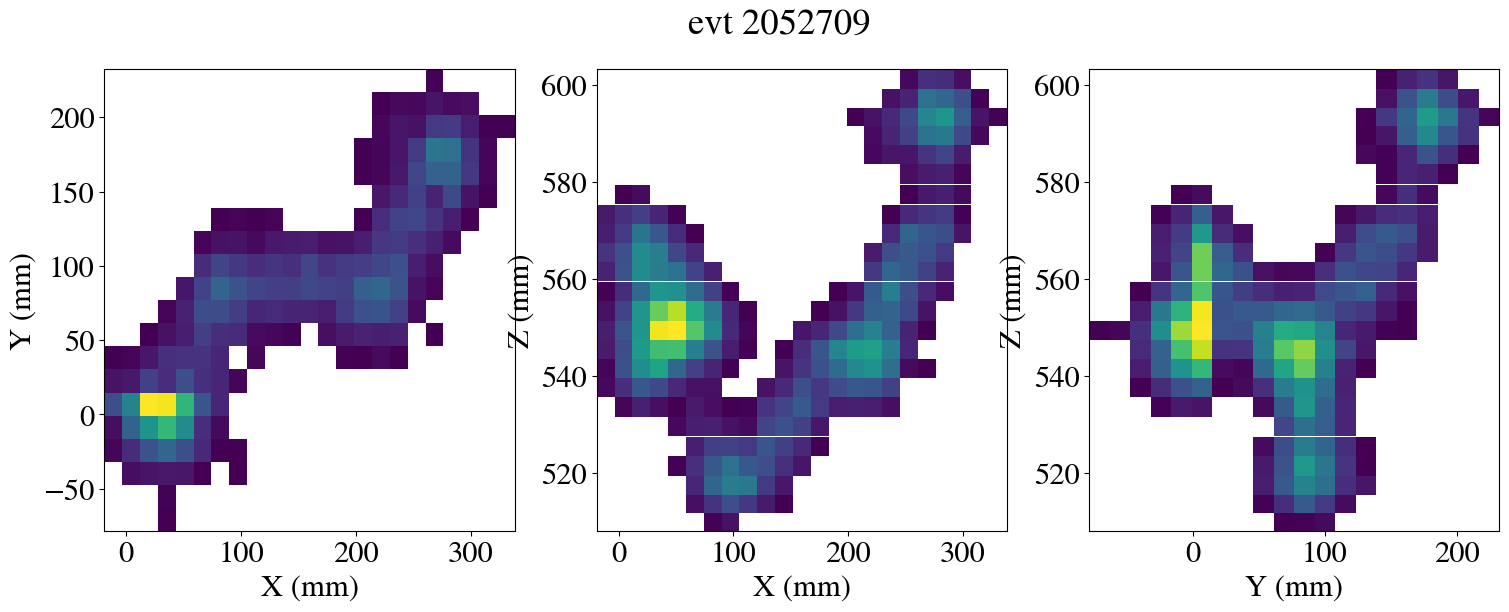

BLOB RADIUS 45


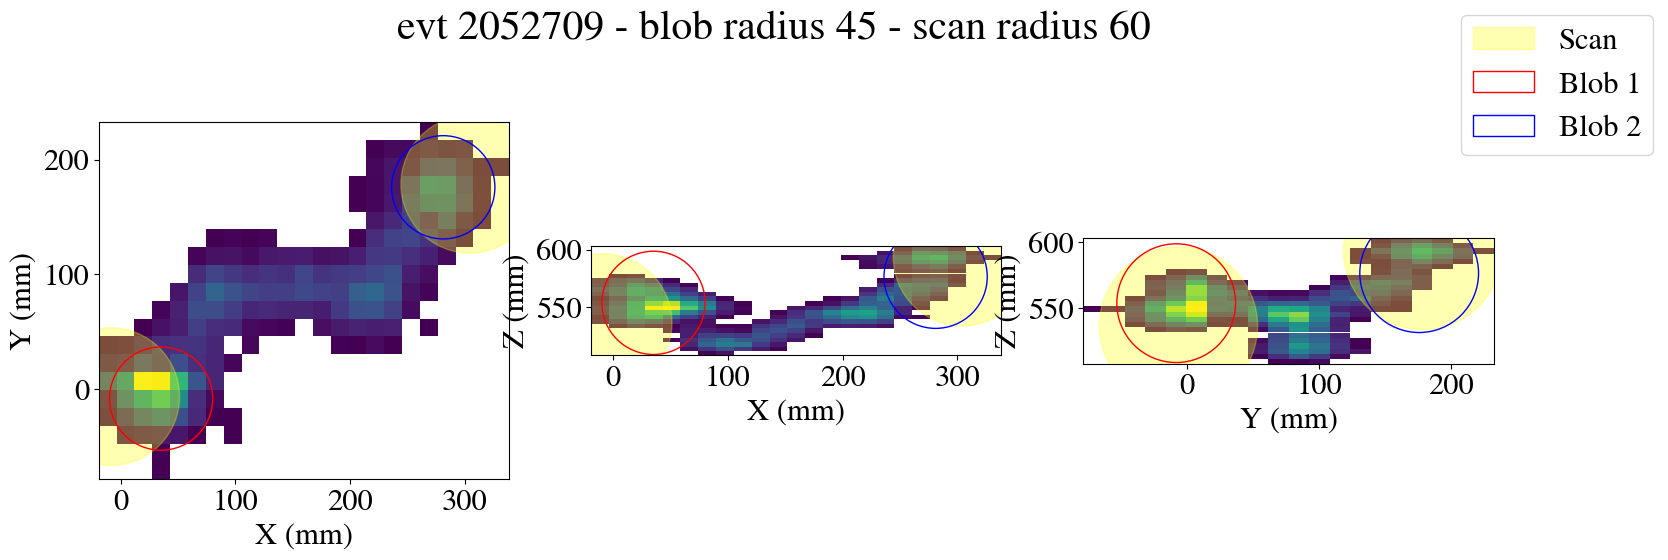

event 2052933


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,2052933,0,1.628531,276.083854,190,934,1,-3.575,291.575,739.288875,...,846.958121,165.475,338.225,788.841838,0.527255,0.397584,0.0,19.270833,20.622222,19.325321


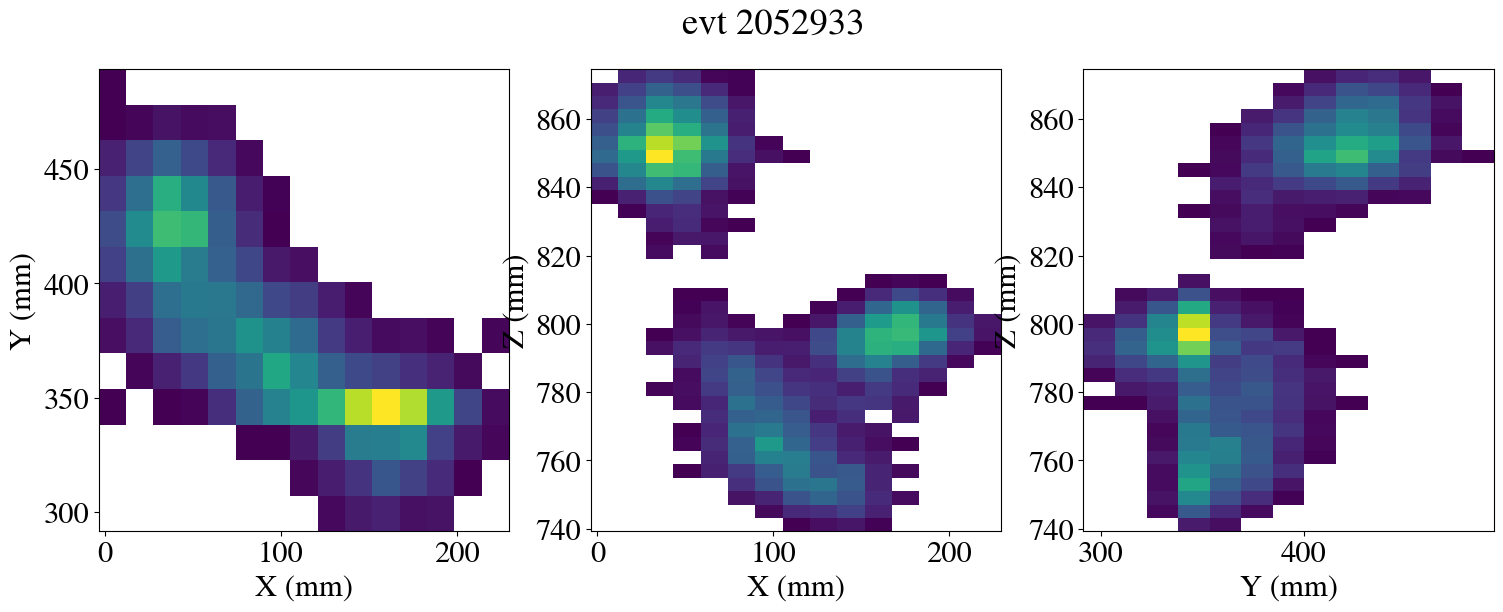

BLOB RADIUS 45


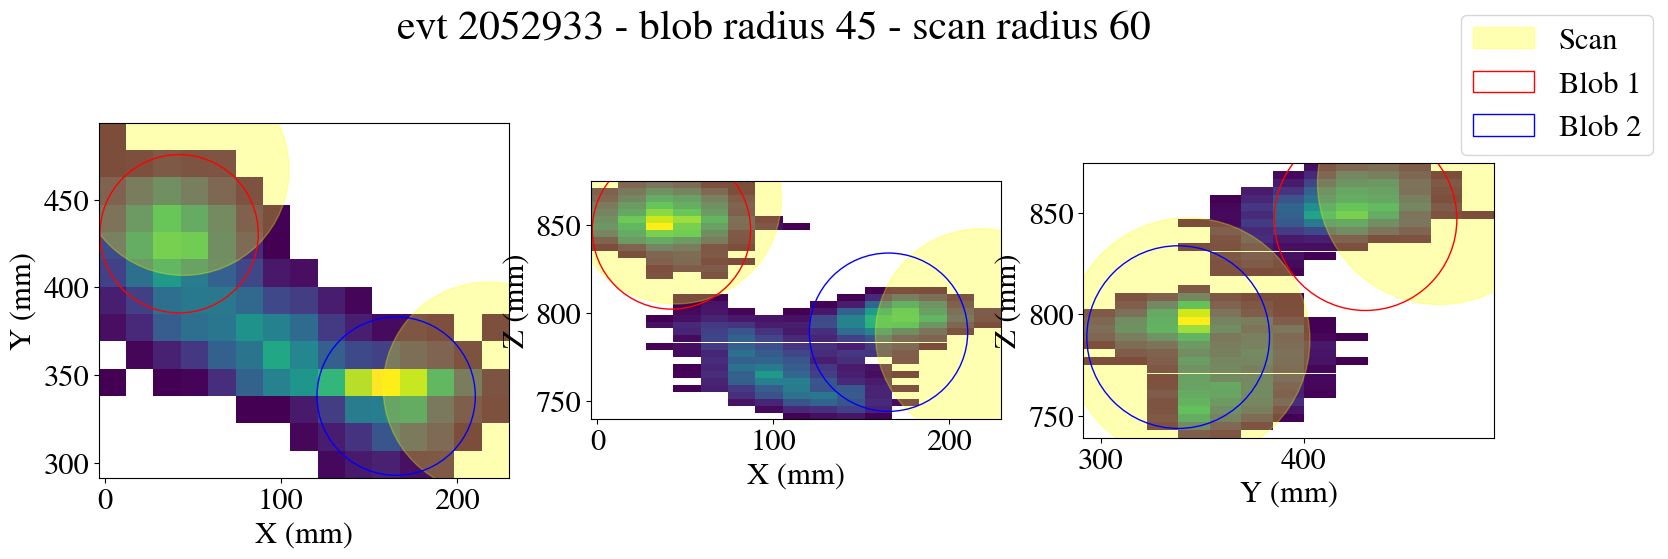

event 2053017


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
14,2053017,0,1.617655,304.245173,173,869,1,-158.075,338.225,517.3645,...,549.083722,-112.425,383.875,654.387331,0.56025,0.376695,0.0,20.180769,19.85,20.894188


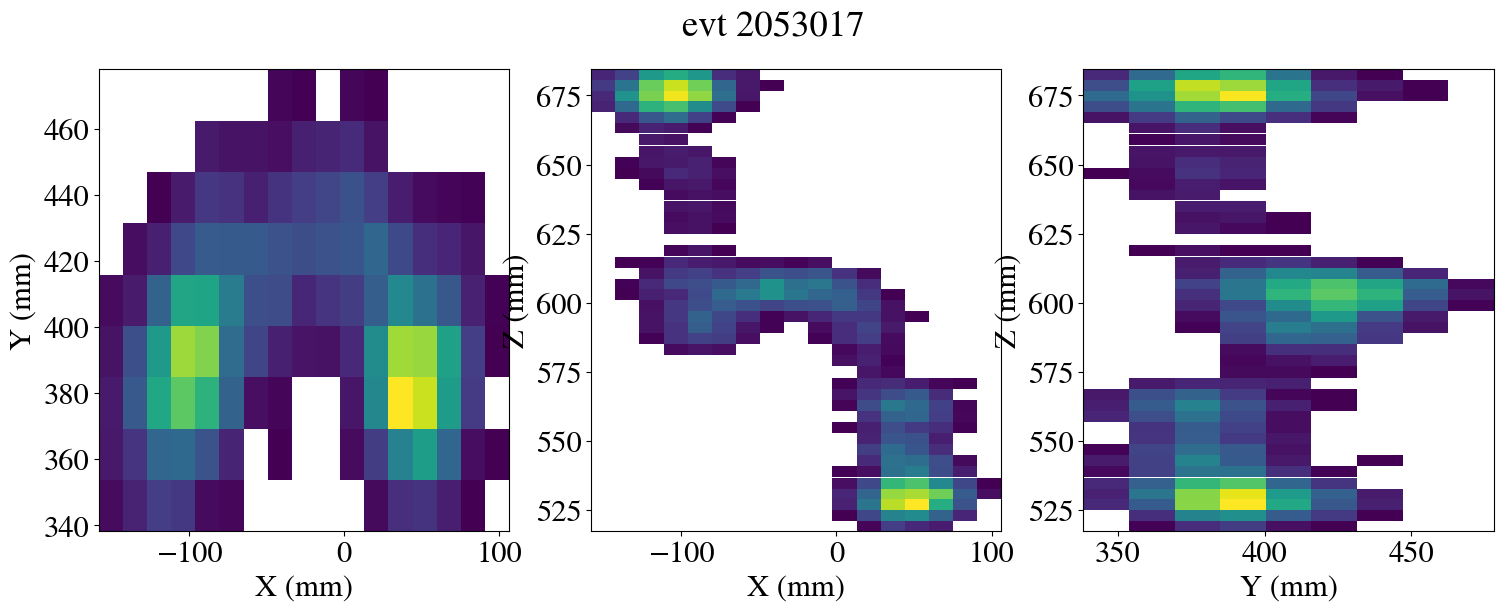

BLOB RADIUS 45


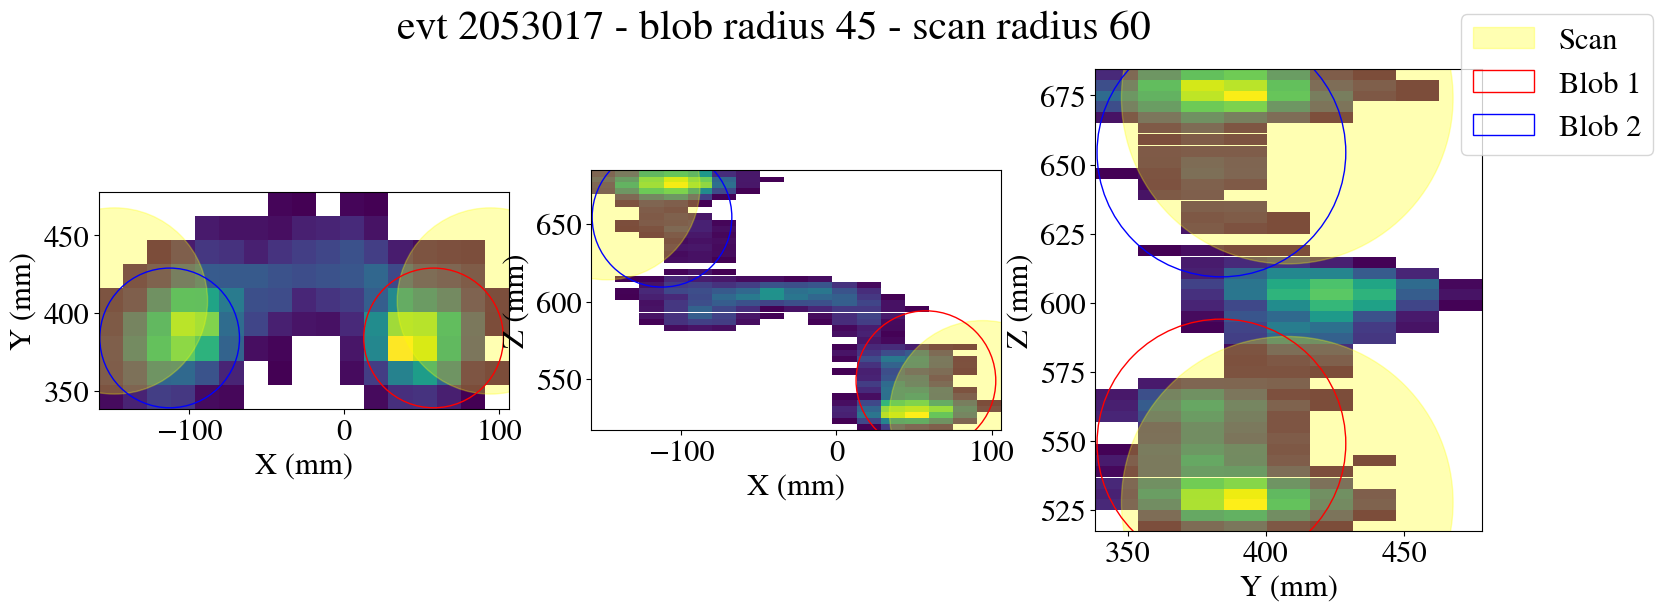

event 2164674


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
28,2164674,0,1.378439,251.239868,206,891,1,26.525,-0.875,706.312,...,733.142096,188.682234,106.975,754.351103,0.499384,0.176471,0.0,20.103846,19.1875,19.016528


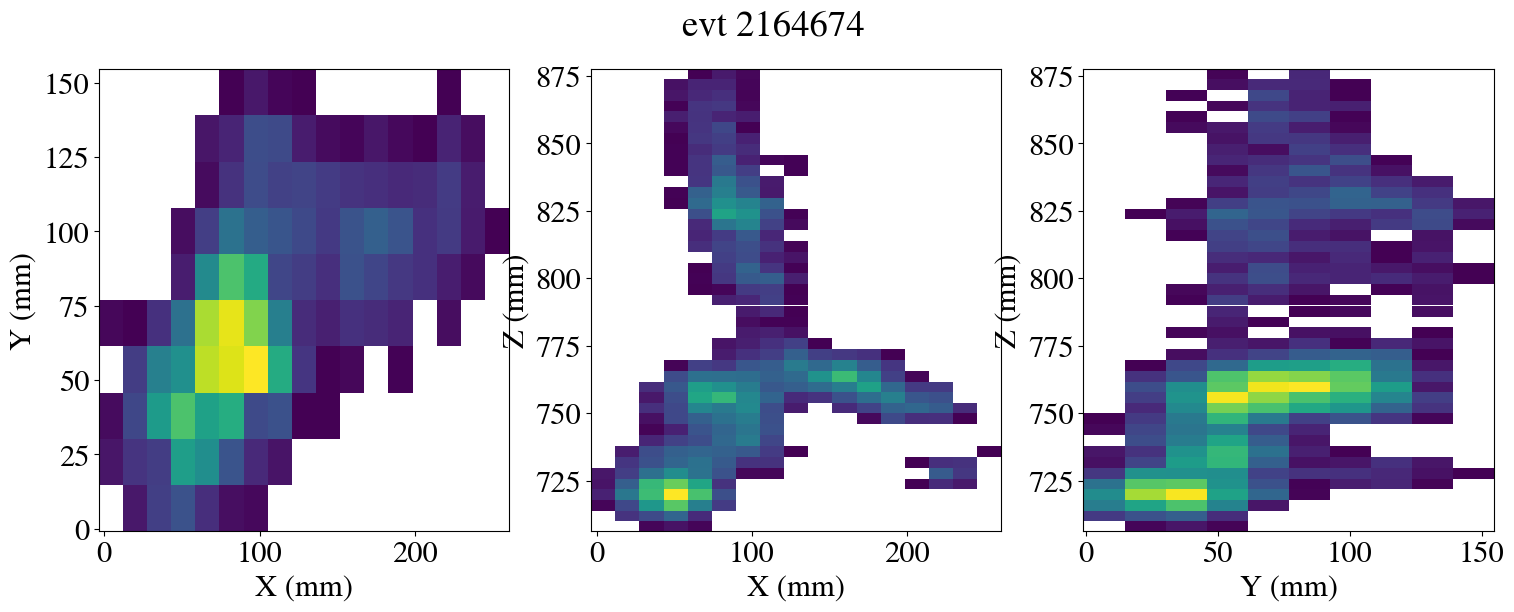

BLOB RADIUS 45


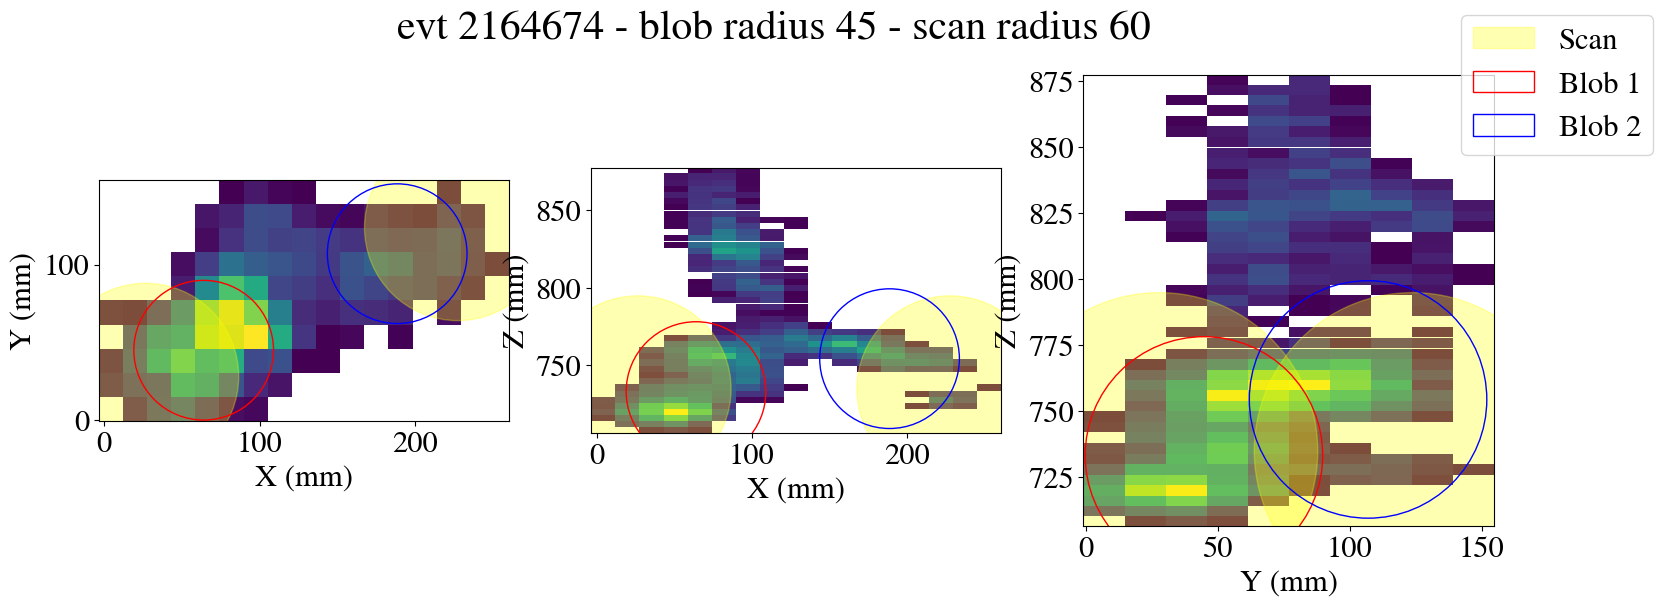

event 545847


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
47,545847,0,1.510665,308.129214,175,850,1,-50.225,13.675,367.28025,...,376.160203,81.197577,81.298541,559.008909,0.487449,0.361828,0.0,20.511111,19.85,20.28245


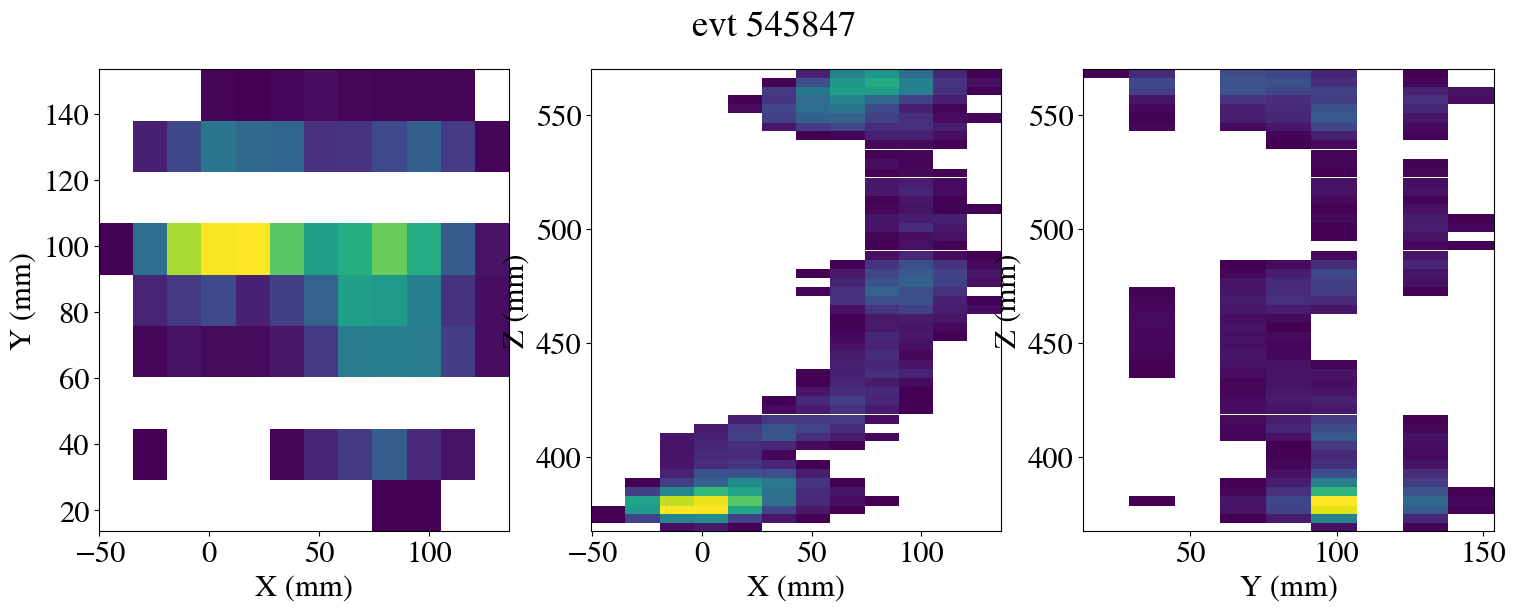

BLOB RADIUS 45


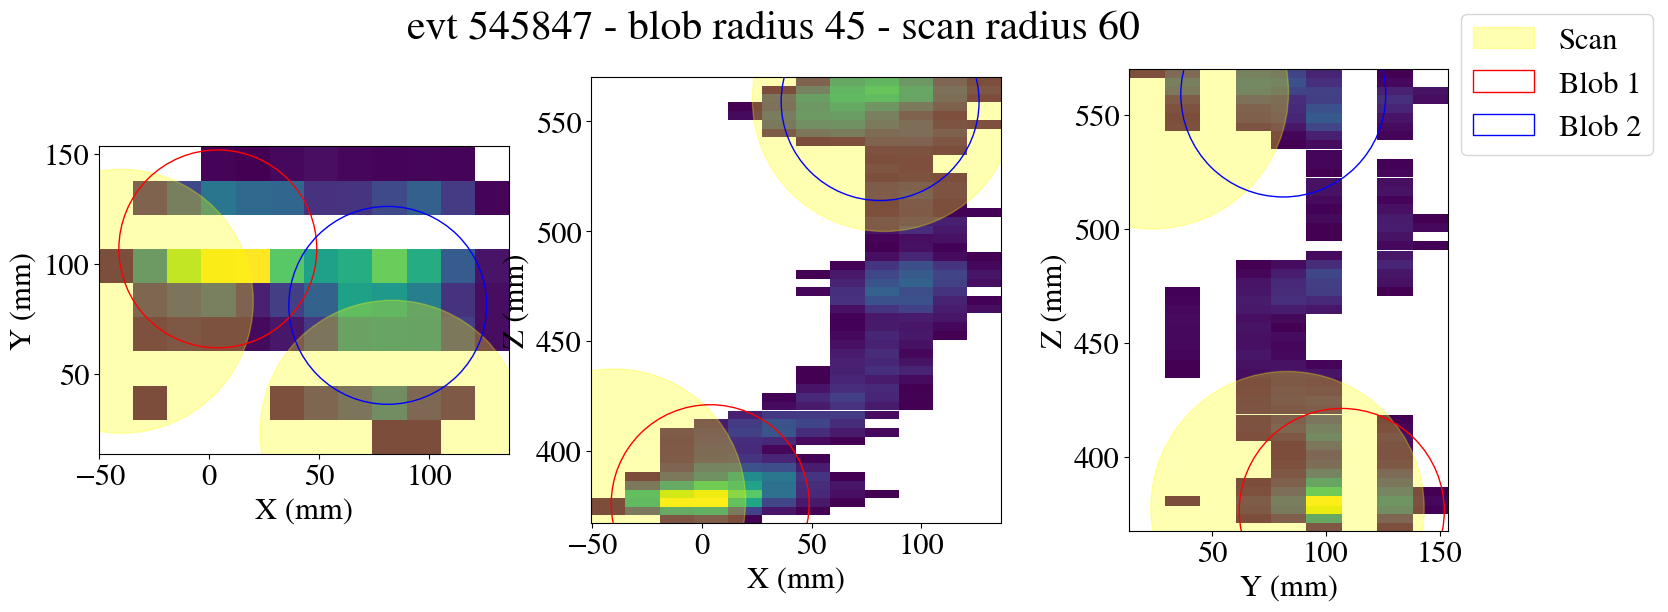

event 406225


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
52,406225,0,1.611591,205.924717,186,866,1,165.475,168.175,445.94675,...,468.881298,196.575,236.395066,469.248296,0.53074,0.281726,0.0,20.115,20.065,16.809531


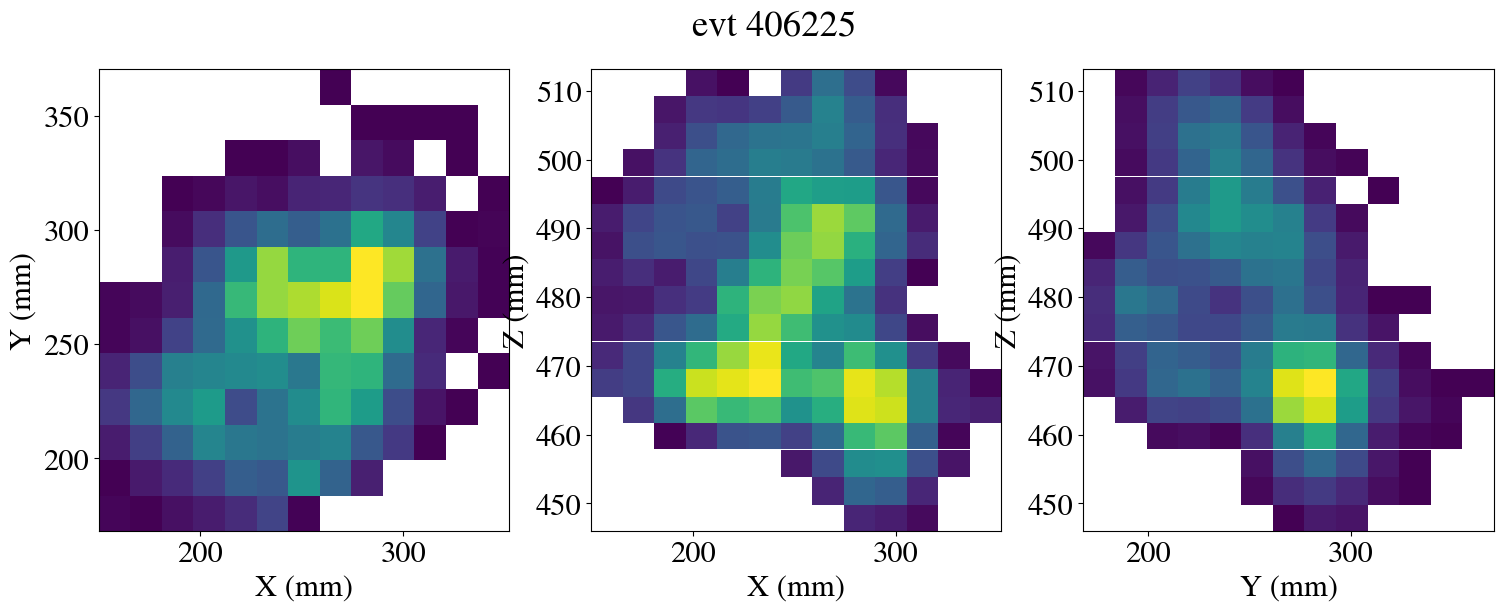

BLOB RADIUS 45


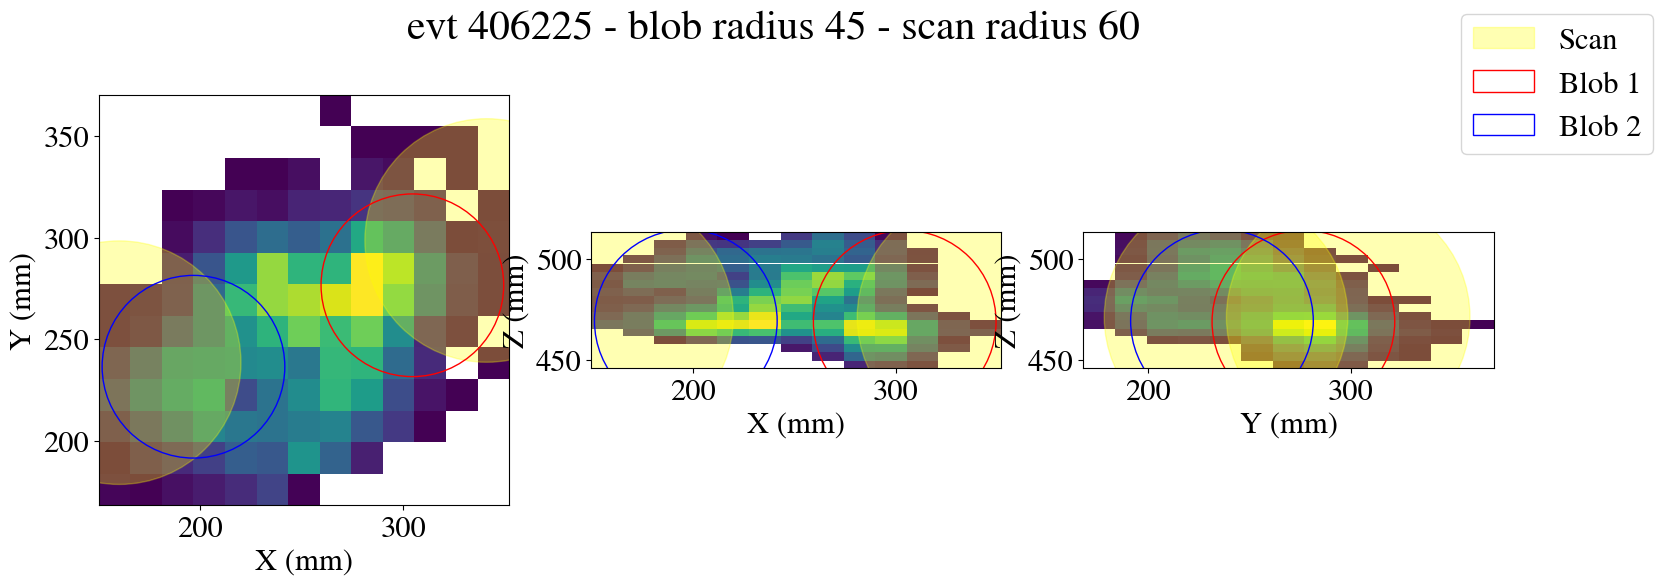

event 406568


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
53,406568,0,1.615016,292.603613,230,991,1,-235.825,214.825,831.744125,...,856.464482,-189.175,291.575,872.639274,0.534007,0.439125,0.0,20.889286,20.511111,16.813031


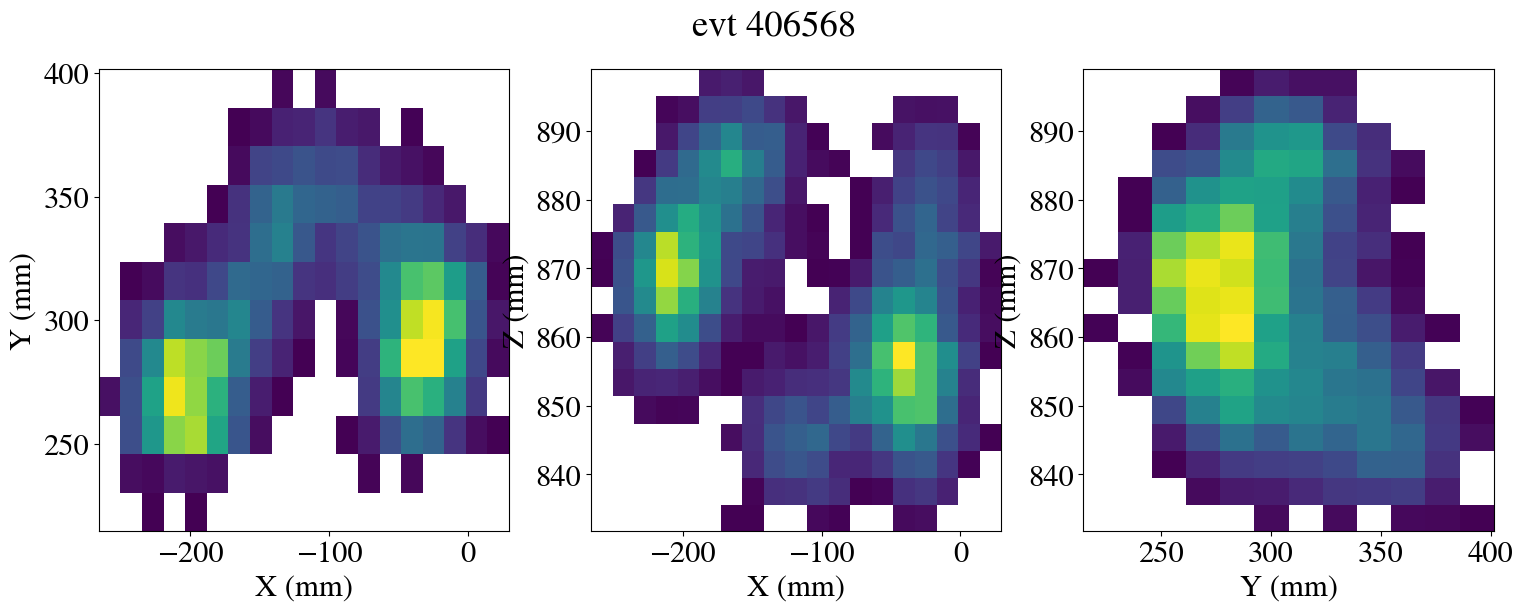

BLOB RADIUS 45


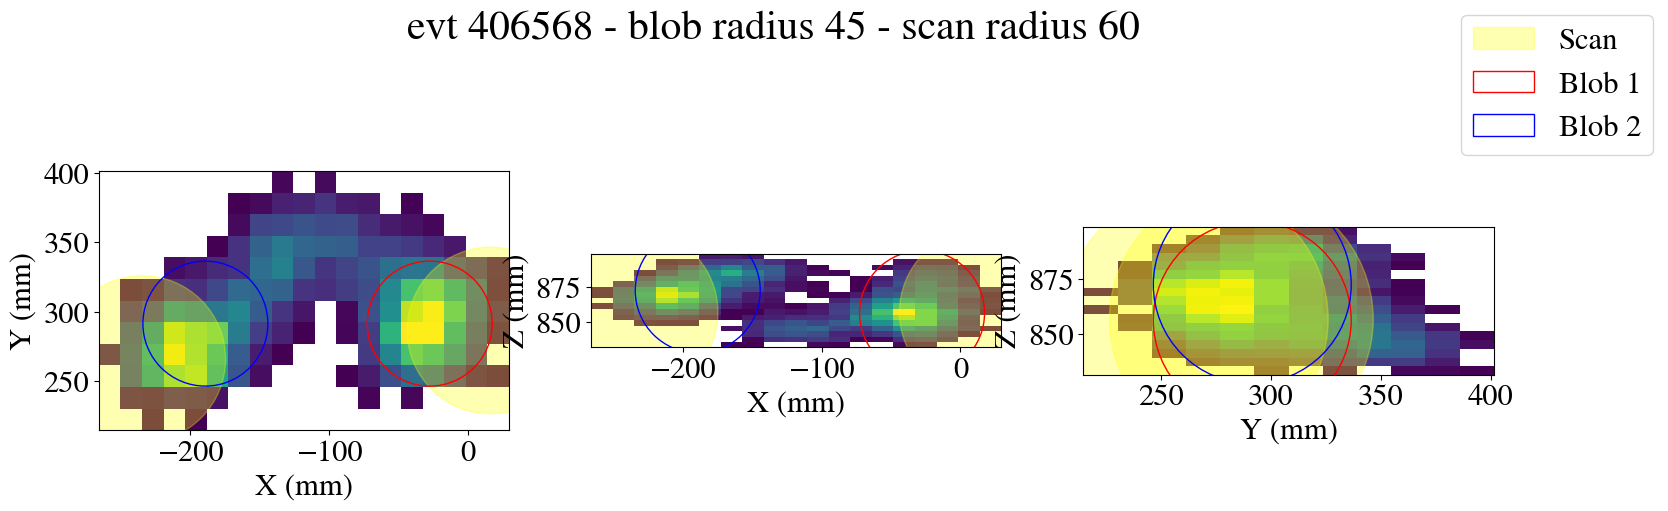

event 406708


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
62,406708,0,1.634907,272.942539,260,1145,1,257.775,-201.525,1217.228625,...,1299.338668,405.568395,-24.516938,1245.188229,0.393291,0.322536,0.0,19.7,19.85,18.193589


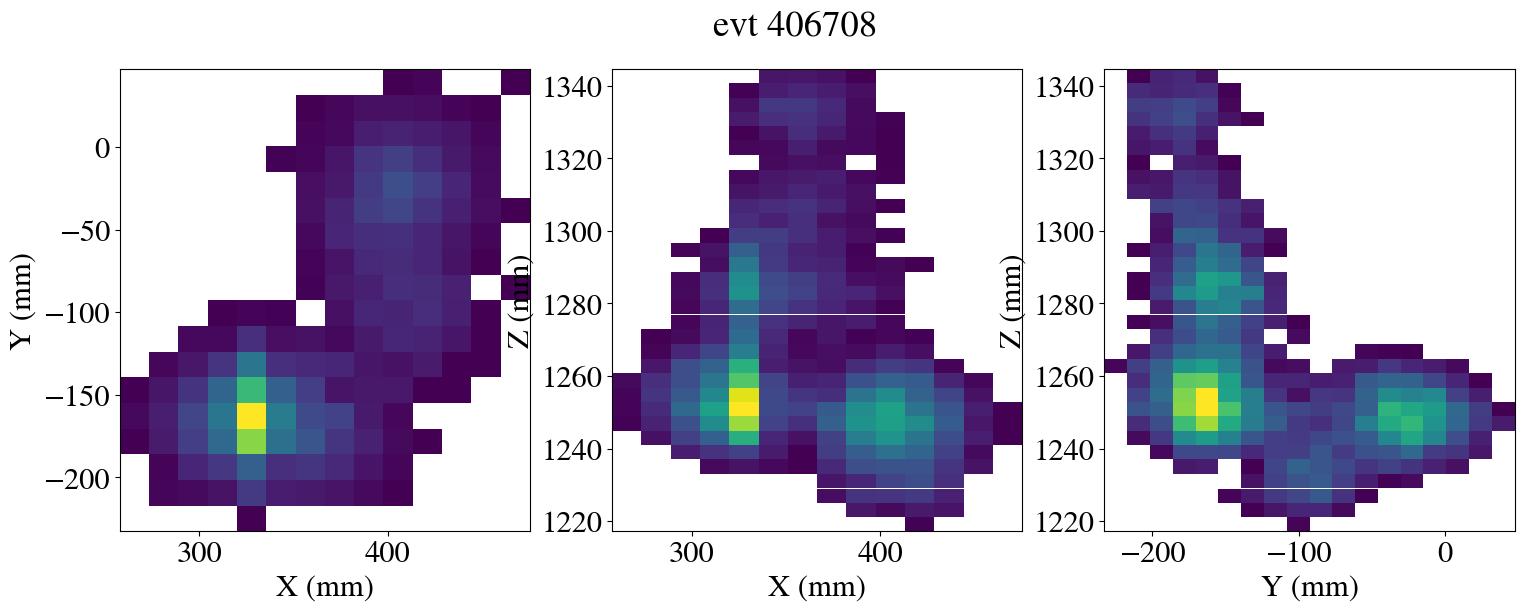

BLOB RADIUS 45


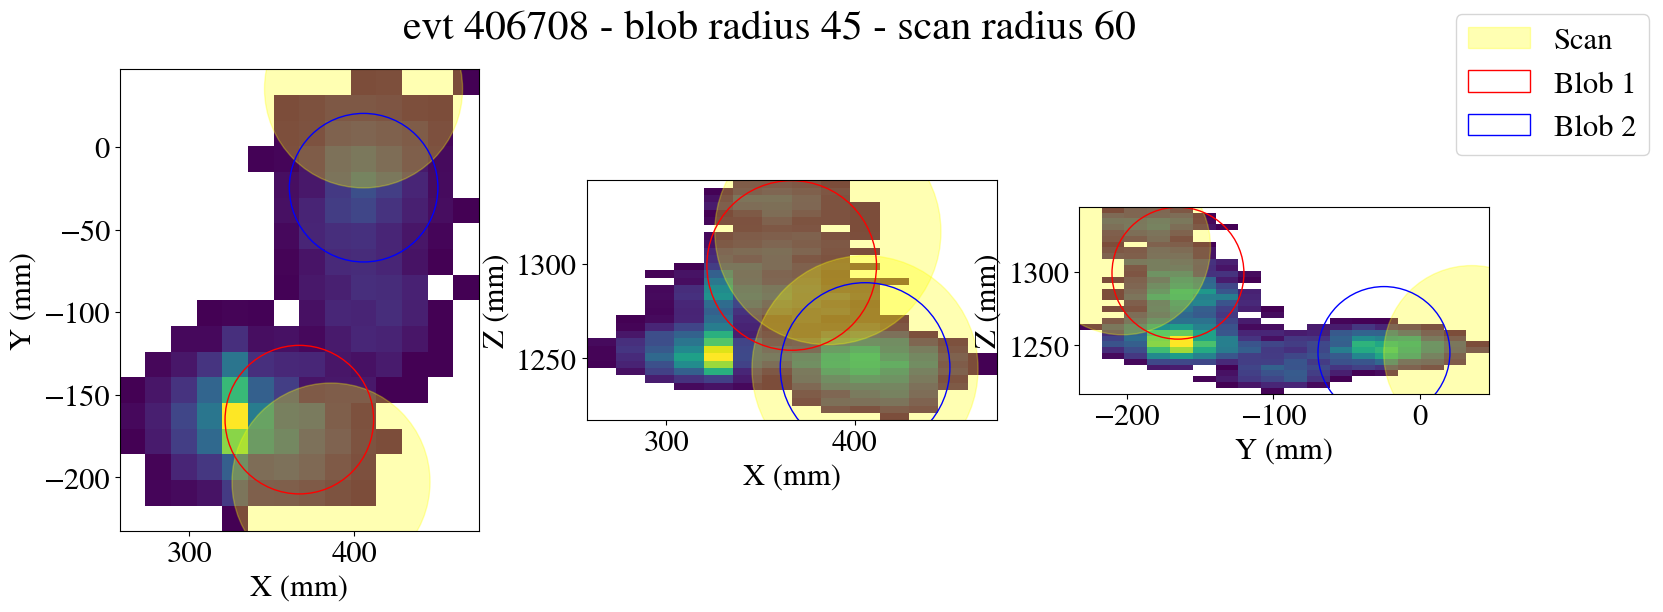

event 816068


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
63,816068,0,1.613391,203.638282,177,841,1,165.475,168.175,714.37825,...,739.55704,219.369647,240.157267,742.686407,0.742808,0.506546,0.020015,19.7,20.566667,16.838188


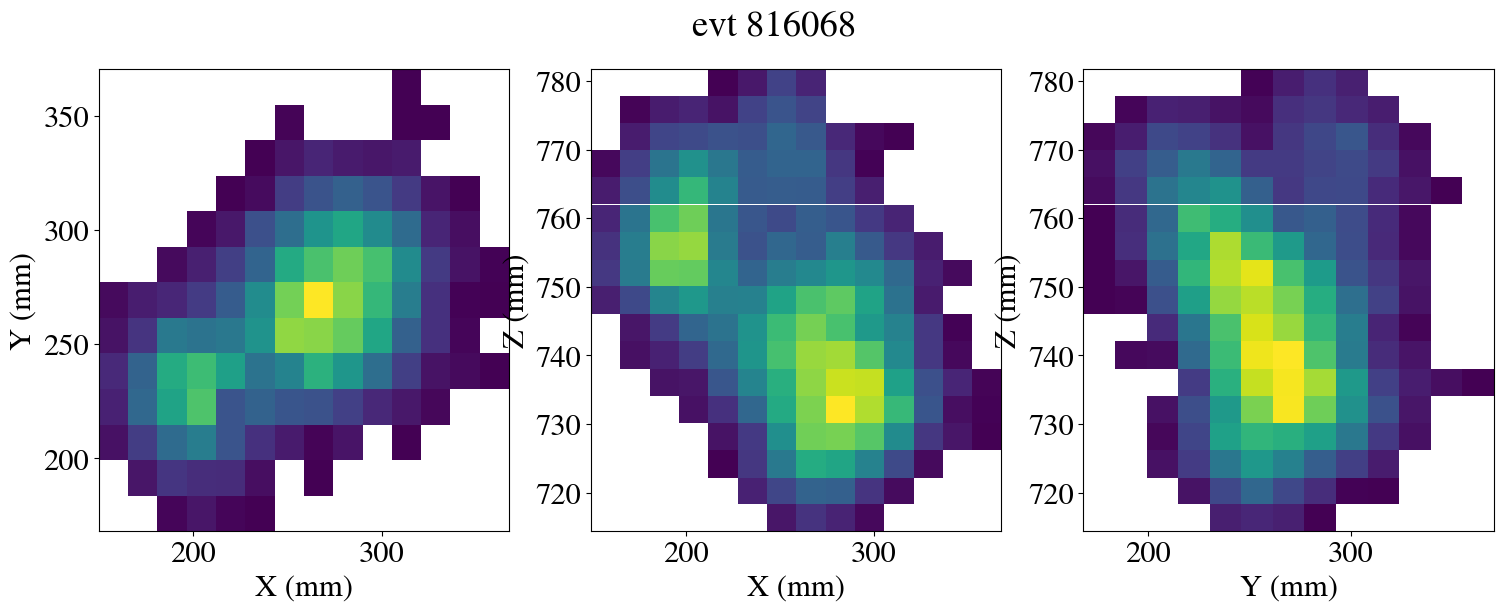

BLOB RADIUS 45


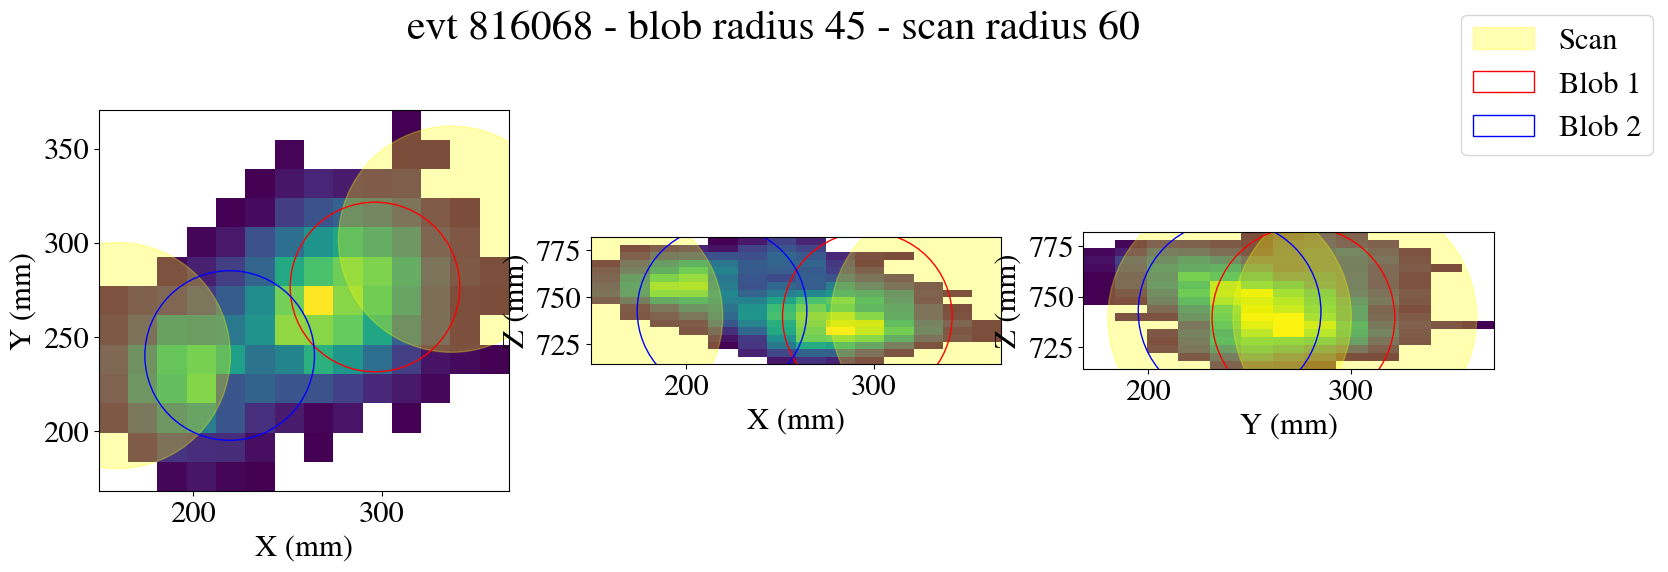

In [7]:
def blob_plotter(q, p, evt, blob_rad, scan_rad, pitch = 15.55, show = False):
    # q is the RECO/Events
    # p is the Tracking/Tracks

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    # PLOT HITS

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');


    # PLOT SCAN RAD
    
    # xy
    circle7 = plt.Circle((p.extreme1_x.values[0], p.extreme1_y.values[0]), scan_rad, color='yellow', fill=True, alpha = 0.3)
    circle8 = plt.Circle((p.extreme2_x.values[0], p.extreme2_y.values[0]), scan_rad, color='yellow', fill=True, label='Scan', alpha = 0.3)

    axes[0].add_patch(circle7)
    axes[0].add_patch(circle8)

    # xz
    circle9 = plt.Circle((p.extreme1_x.values[0], p.extreme1_z.values[0]), scan_rad, color='yellow', fill=True, alpha = 0.3)
    circle10 = plt.Circle((p.extreme2_x.values[0], p.extreme2_z.values[0]), scan_rad, color='yellow', fill=True, alpha = 0.3)

    axes[1].add_patch(circle9)
    axes[1].add_patch(circle10)

    # yz
    circle11 = plt.Circle((p.extreme1_y.values[0], p.extreme1_z.values[0]), scan_rad, color='yellow', fill=True, alpha = 0.3)
    circle12 = plt.Circle((p.extreme2_y.values[0], p.extreme2_z.values[0]), scan_rad, color='yellow', fill=True, alpha = 0.3)

    axes[2].add_patch(circle11)
    axes[2].add_patch(circle12)


    # PLOT BLOB RAD

    # xy
    circle1 = plt.Circle((p.blob1_x.values[0], p.blob1_y.values[0]), blob_rad, color='r', fill=False, label='Blob 1')
    circle2 = plt.Circle((p.blob2_x.values[0], p.blob2_y.values[0]), blob_rad, color='b', fill=False, label='Blob 2')

    axes[0].add_patch(circle1)
    axes[0].add_patch(circle2)

    # xz
    print(f'BLOB RADIUS {blob_rad}')
    circle3 = plt.Circle((p.blob1_x.values[0], p.blob1_z.values[0]), blob_rad, color='r', fill=False)
    circle4 = plt.Circle((p.blob2_x.values[0], p.blob2_z.values[0]), blob_rad, color='b', fill=False)

    axes[1].add_patch(circle3)
    axes[1].add_patch(circle4)

    # yz
    circle5 = plt.Circle((p.blob1_y.values[0], p.blob1_z.values[0]), blob_rad, color='r', fill=False)
    circle6 = plt.Circle((p.blob2_y.values[0], p.blob2_z.values[0]), blob_rad, color='b', fill=False)

    axes[2].add_patch(circle5)
    axes[2].add_patch(circle6)


    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[2].set_aspect('equal')

    #axes[0].set_xlim(q.blob1_x.values[0] - 20, q.blob1_x.values[0] + 20)
    #axes[0].set_ylim(q.blob1_y.values[0] - 20, q.blob1_y.values[0] + 20)

    


    #axes[0].set_xlim(q.blob1_x.values[0] - 20, q.blob1_x.values[0] + 20)
    #axes[0].set_ylim(q.blob1_y.values[0] - 20, q.blob1_y.values[0] + 20)

    fig.legend()
    fig.suptitle(f"evt {evt} - blob radius {blob_rad} - scan radius {scan_rad}", fontsize = 30)
    if show:
        plt.show()

for event_num in reco.event.unique():

    # one track events only please :)
    if tracking[tracking.event == event_num].numb_of_tracks.values[0] == 1:

        print('=' * 20)
        print('=' * 20)
        print(f'event {event_num}')
        print('=' * 20)
        print('=' * 20)
        # extract topological info related to this event
        display(tracking[tracking.event == event_num])

        raw_plotter(reco[reco.event == event_num], event_num, show = True)

    

        blob_plotter(reco[reco.event == event_num], tracking[tracking.event == event_num], event_num, BLOB_RADIUS, SCAN_RADIUS, show = True)


In [8]:
from itertools import cycle, islice

coordinates = ['x', 'y', 'z']
coordinate_pairs = list(zip(coordinates, islice(cycle(coordinates), 1, None)))
print(coordinate_pairs)

[('x', 'y'), ('y', 'z'), ('z', 'x')]


In [9]:
display(tracking)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,2052485,0,1.590687,240.050234,194,1066,3,149.925,137.075,643.021875,...,724.508634,319.975000,229.875000,727.449764,0.360027,0.344209,0.000000,20.685526,20.302632,20.856233
1,2052485,1,0.126966,50.060234,8,55,3,257.775,337.725,589.050750,...,599.999858,280.788109,353.275000,599.999858,0.126966,0.126966,0.126966,20.685526,20.302632,20.856233
2,2052485,2,0.044048,28.984269,3,8,3,-389.325,14.175,1500.453750,...,1502.038955,-375.707830,29.725000,1502.038955,0.044048,0.044048,0.044048,20.685526,20.302632,20.856233
3,2052576,0,1.312759,234.078649,156,741,3,-389.325,-324.925,1191.078875,...,1205.939629,-281.475000,-155.875000,1223.922636,0.552943,0.273783,0.000000,20.542857,20.545833,20.708624
4,2052576,1,0.217994,70.145758,14,104,3,-250.375,60.325,740.131813,...,752.210176,-213.278176,106.975000,752.210176,0.204831,0.204831,0.204831,20.542857,20.545833,20.708624
5,2052576,2,0.214005,61.637500,10,92,3,-50.225,-63.075,1831.029500,...,1846.431846,-11.120840,-38.658927,1846.431846,0.211461,0.211461,0.211461,20.542857,20.545833,20.708624
6,2052646,0,1.184963,221.684790,138,624,4,165.475,214.825,1075.742750,...,1178.807806,235.468555,360.495469,1089.242094,0.547350,0.198521,0.000000,20.302632,20.689024,20.876209
7,2052646,1,0.168649,70.364814,12,87,4,-34.675,106.975,2483.016500,...,2493.497346,-9.785653,152.625000,2493.497346,0.165885,0.165885,0.165885,20.302632,20.689024,20.876209
8,2052646,2,0.163820,78.276163,18,78,4,-81.325,-433.275,226.599719,...,239.040672,-34.675000,-386.625000,239.040672,0.160088,0.160088,0.160088,20.302632,20.689024,20.876209
9,2052646,3,0.029517,20.302632,2,4,4,73.175,106.975,2440.592000,...,2440.592000,88.725000,112.518368,2440.592000,0.029517,0.029517,0.029517,20.302632,20.689024,20.876209


# plot in 3D

In [10]:

def plotter_3d(df, 
               evt,
               blob1xyz,
               blob2xyz,
               blobR,
               rotate,
               cut_n_drop = True,
               show = True,
               clrbar = True,
               alpha = 0.65,
               min_s = 1, max_s = 15, cut_sensors = None, drop_sensors = None):
    '''
    evt_interest - df
    evt          - event number

    '''
    # plot
    evt_interest = df[df.event == evt]

    if cut_n_drop:
        hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    else:
        hits_drop = evt_interest.copy(deep = True)
    
    xt = hits_drop.X
    yt = hits_drop.Y
    zt = hits_drop.Z
    et = hits_drop.E
    
    fig = plt.figure()
    #fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
    fig.suptitle(f'Electron candidate event {evt}', fontsize=30)
    ax = fig.add_subplot(111, projection='3d')
    
    
    
    ets = et > 0 # eliminate small things for measurement
    
    max_val = max(et[ets])
    scaled_clipped = [max((v / max_val) * max_s, min_s) for v in et[ets]]

    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    #plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
    p = ax.scatter([xt[ets]], yt[ets], zt[ets], c=et[ets], alpha=alpha, cmap='viridis', s = scaled_clipped)#, s = et[ets])
    #q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')
    
    # overlay the blobs and their radii
    if clrbar:
        cb = fig.colorbar(p, ax=ax)
        cb.set_label('Energy (keV)')
    
    # Define sphere parameters

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = blobR * np.outer(np.cos(u), np.sin(v))
    y = blobR * np.outer(np.sin(u), np.sin(v))
    z = blobR * np.outer(np.ones(np.size(u)), np.cos(v))

    
    ax.plot_surface(blob1xyz[0] + x, blob1xyz[1] + y, blob1xyz[2] + z, color='r', alpha=0.5)

    # Plot sphere for blob2
    ax.plot_surface(blob2xyz[0] + x, blob2xyz[1] + y, blob2xyz[2] + z, color='b', alpha=0.5)

    # Set equal aspect ratio for the axes to make spheres appear as circles
    # Set equal limits for x, y, z axes to ensure equal dimensions
    ax.set_xlim(blob1xyz[0] - 100, blob1xyz[0] + 100)
    ax.set_ylim(blob1xyz[1] - 100, blob1xyz[1] + 100)
    ax.set_zlim(blob1xyz[2] - 100, blob1xyz[2] + 100)
    # overlay blobs and radiii

    ax.set_xlabel('\nx (mm)')
    ax.set_ylabel('\ny (mm)')
    ax.set_zlabel('\nz (mm)')
    
    #ax.set_xlim([-300, -100])
    #ax.set_ylim([250, 450])
    #ax.set_zlim([1600, 1800])
    ax.view_init(20, rotate)
    
    fig.savefig(f'/scratch/halmazan/NEXT/testing/notebooks/checks/gif_making/angle_{rotate}.png')
    ####plt.savefig(f'plots/hits_3d_{evt}.pdf')
    if show:
        plt.show()

    return hits_drop

In [11]:
event_num = 2052709
blob_relevant = tracking[(tracking.event == event_num)]
blobR = 50
#display(blob_relevant.blob1_x)
#print(blob_relevant.columns)
blob1xyz = [blob_relevant.blob1_x.values[0], blob_relevant.blob1_y.values[0], blob_relevant.blob1_z.values[0]]
blob2xyz = [blob_relevant.blob2_x.values[0], blob_relevant.blob2_y.values[0], blob_relevant.blob2_z.values[0]]
print(blob1xyz)
print(blob2xyz)

[35.207401746414554, -8.35045911318674, 553.8274142731665]
[281.1539441336062, 175.81499971276102, 576.5790448317862]


In [12]:


# then force the blobs onto it??? can we even do that now?
# Add spheres for the blobs
#blob1 = tracking[(tracking.event == event_num) & (tracking.trackID == 0)][['blob1_x', 'blob1_y', 'blob1_z']].iloc[0]
#blob2 = tracking[(tracking.event == event_num) & (tracking.trackID == 0)][['blob2_x', 'blob2_y', 'blob2_z']].iloc[0]
#plotter_3d(reco, event_num, blob1xyz, blob2xyz, blobR, cut_n_drop = False, show = False, min_s = 1, max_s = 500)


for i in tqdm(range(1, 360)):
    plotter_3d(reco, event_num, blob1xyz, blob2xyz, blobR, i, cut_n_drop = False, show = False, min_s = 250, max_s = 5000)
    plt.close('all')




100%|███████████████████████████████████████████████████████████████████████████████| 359/359 [02:40<00:00,  2.24it/s]


In [13]:
import re

# human sorting
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]


In [14]:
from pathlib import Path

import imageio

# Path to the directory containing PNGs
png_dir = ('/scratch/halmazan/NEXT/testing/notebooks/checks/gif_making/')
files = [f for f in os.listdir(png_dir) if os.path.isfile(os.path.join(png_dir, f))]

# Collect all PNG files and sort them
png_files = sorted(files, key=alphanum_key)

# Output GIF path
output_gif = png_dir + 'gifs/output.gif'



In [15]:

images = []
for filename in png_files:
    images.append(imageio.imread(png_dir + filename))
    

print("Creating gif...")
gif_name = f'/scratch/halmazan/NEXT/testing/notebooks/checks/gif_making/gifs/{event_num}.gif'
imageio.mimsave(gif_name, images, loop = 0, fps = 15)

/tmp/ipykernel_127897/1618942860.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(png_dir + filename))


Creating gif...
